**Author:** Max Aragón <br>
**Professor:** Charlotte Pelletier <br>
**Affiliations:** Université Bretagne Sud<br>
**Course:** Deep learning <br>
**Date:** 2023-01-18

<div class="alert alert-block alert-success">
<h2><center>Satellite image classification</center></h2>

In [ ]:
!pip install matplotlib --upgrade
!pip install timm
!pip install fastbook

In [ ]:
import os
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import timm
from fastbook import *
from fastai.vision.data import *
from fastai.vision.all import *
from torchvision.utils import make_grid

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'); device

## Number of images per class

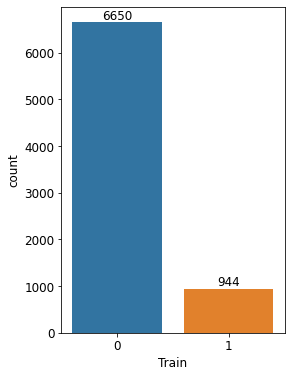

In [ ]:
if os.getcwd() != '/content/drive/MyDrive/Colab_Notebooks/PlanetX':
    os.chdir('/content/drive/MyDrive/Colab_Notebooks/PlanetX')


df = pd.read_csv('traindata.csv')

X = df['img_id']
y = df['has_oilpalm']

fig, ax1 = plt.subplots(figsize=(4,6))

counts = y.value_counts()

ax1 = sns.countplot(x=y, ax=ax1)
ax1.bar_label(container=ax1.containers[0], labels=counts)
ax1.set_xlabel('Train')
plt.show()

## What image models work the best? (inference test on Imagenet)

ref: https://www.kaggle.com/code/jhoward/which-image-models-are-best

In [ ]:
!git clone --depth 1 https://github.com/rwightman/pytorch-image-models.git

%cd pytorch-image-models/results

df_results = pd.read_csv('results-imagenet.csv')

def get_data(part, col):
    df = pd.read_csv(f'benchmark-{part}-amp-nhwc-pt111-cu113-rtx3090.csv').merge(df_results, on='model')
    df['secs'] = 1. / df[col]
    df['family'] = df.model.str.extract('^([a-z]+?(?:v2)?)(?:\d|_|$)')
    df = df[~df.model.str.endswith('gn')]
    df.loc[df.model.str.contains('in22'),'family'] = df.loc[df.model.str.contains('in22'),'family'] + '_in22'
    df.loc[df.model.str.contains('resnet.*d'),'family'] = df.loc[df.model.str.contains('resnet.*d'),'family'] + 'd'
    return df[df.family.str.contains('^re[sg]netd?|beit|convnext|levit|efficient|vit|vgg|swin')]

df_models = get_data('infer', 'infer_samples_per_sec')


w,h = 800,600

def show_all(df, title, size):
    return px.scatter(df_models, width=w, height=h, size=df[size]**2, title=title,
        x='secs',  y='top1', log_x=True, color='family', hover_name='model', hover_data=[size])
    
show_all(df_models, 'Inference', 'infer_img_size')

## Ranking models based on speed inference and accuracy

In [ ]:
def ranking_models(df_models):
  df = pd.DataFrame(df_models, columns=['model', 'family', 'top1', 'secs'])
  # Min-max and max-min normalisation of accuracy and speed
  min_val = df["top1"].min()
  max_val = df["top1"].max()
  min_val_m = df["secs"].min()
  max_val_m = df["secs"].max()
  df["norm_accuracy"] = (df["top1"] - min_val) / (max_val - min_val)
  df["norm_speed"] = abs((df["secs"] - max_val_m) / (min_val_m - max_val_m))
  df["score"] = df["norm_accuracy"] + df["norm_speed"]
  df = df.sort_values(['score'], ascending=[False])
  return df

def find_models(rank):
  model_list = list(rank.family.unique()[:3]);
  first_models = rank.loc[rank['family'].isin(model_list)].groupby('family').head(1)
  return first_models

In [ ]:
rank = ranking_models(df_models); rank

,model,family,top1,secs,norm_accuracy,norm_speed,score
360,swin_large_patch4_window7_224,swin,86.320,0.002185,0.954966,0.960809,1.915775
390,swin_base_patch4_window12_384,swin,86.432,0.004700,0.961057,0.914716,1.875773
314,swin_base_patch4_window7_224,swin,85.252,0.001254,0.896878,0.977865,1.874743
343,regnetz_e8,regnetz,85.030,0.001646,0.884804,0.970683,1.855486
408,swin_large_patch4_window12_384,swin,87.148,0.007950,1.000000,0.855157,1.855157
...,...,...,...,...,...,...,...
172,vgg13,vgg,69.926,0.000495,0.063309,0.991781,1.055090
12,resnet18,resnet,69.748,0.000092,0.053628,0.999160,1.052788
47,mobilevit_xxs,mobilevit,68.912,0.000195,0.008158,0.997278,1.005436
1,regnetx_002,regnetx,68.762,0.000056,0.000000,0.999825,0.999825


## Finding 'best' models per familiy (top 3)

In [ ]:
models2train = find_models(rank); models2train = list(models2train.model); models2train

['swin_large_patch4_window7_224', 'regnetz_e8', 'resnetrs200']

## Data loading without augmentation

Parameters:

* `path` The folder where to work
* `csv_fname:` image name and labels
* `valid_pct:` validation percentage
* `item_tfm = Resize(256)` One or several transforms applied to the items before batching them
* `batch_tfms = None` One or several transforms applied to the batches once they are formed
* `bs = 32` batch size
* `size = 224` 
* `num_workers = 4` 
* `device = device` GPU or CPU


In [ ]:
if os.getcwd() != '/content/drive/MyDrive/Colab_Notebooks/PlanetX':
    os.chdir('/content/drive/MyDrive/Colab_Notebooks/PlanetX')

In [ ]:
dls_original = ImageDataLoaders.from_csv(path='dataset',  
                                csv_fname='traindata.csv', 
                                valid_pct=0.2,
                                item_tfms=Resize(224), 
                                batch_tfms=None,
                                bs = 32,
                                size = 224,
                                device=device)

In [ ]:
print(f'Number of training files: {len(dls_original.train_ds)}')
print(f'Number of validation files: {len(dls_original.valid_ds)}')

Number of training files: 6076
Number of validation files: 1518


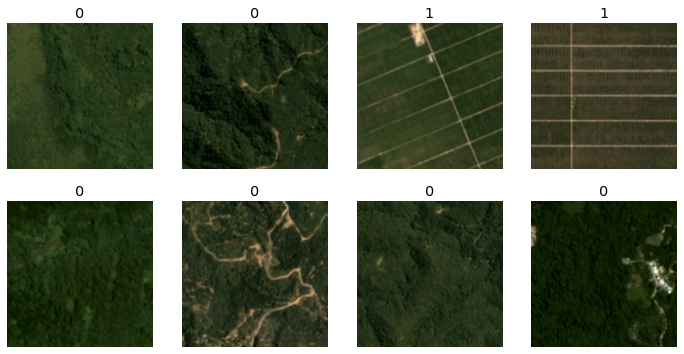

In [ ]:
dls_original.train.show_batch(max_n=8)

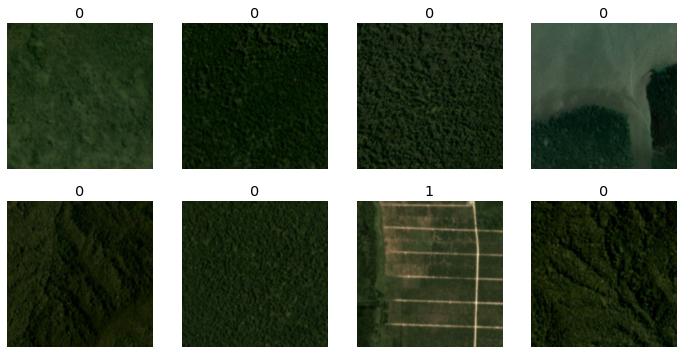

In [ ]:
dls_original.valid.show_batch(max_n=8)

# Model training

In [ ]:
def train_model(dls_original, models2train, loss_func=None, opt_func=Adam, num_epochs=10):
  for model in models2train:
    print('-' * 10)
    print(model)
    print('-' * 10)
    learn = vision_learner(dls_original, arch=str(model), normalize=True, n_out=None, pretrained=True,
                  loss_func=loss_func, opt_func=opt_func, splitter=None, cbs=None, metrics=[accuracy,F1Score()], path=None,
                  model_dir='models', wd=None, wd_bn_bias=False,
                  train_bn=True, moms=(0.95, 0.85, 0.95), cut=None,
                  custom_head=None, concat_pool=True, pool=True, lin_ftrs=None, ps=0.5,
                  first_bn=True, bn_final=False, lin_first=False,
                  y_range=None, n_in=3).to_fp16()
    lrs = learn.lr_find()
    base_lr = lrs.valley
    learn.fine_tune(epochs=num_epochs, base_lr=base_lr, cbs=ShowGraphCallback())
    learn.export(f"model_{model}")

----------
swin_large_patch4_window7_224
----------


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.318810,0.205966,0.932148,0.740554,00:30


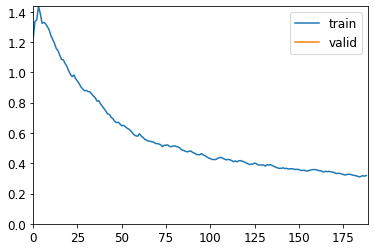

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.245312,0.207857,0.934783,0.753117,00:39
1,0.241993,0.198675,0.938735,0.766917,00:39
2,0.214220,0.191143,0.939394,0.770000,00:39
3,0.194977,0.181432,0.939394,0.765306,00:39
4,0.197623,0.205900,0.916996,0.622754,00:39
5,0.210847,0.201025,0.934783,0.764846,00:39
6,0.192993,0.202682,0.935441,0.767773,00:39
7,0.195163,0.198933,0.934783,0.765957,00:39
8,0.183770,0.183318,0.938076,0.772947,00:39
9,0.180354,0.183935,0.939394,0.775610,00:39


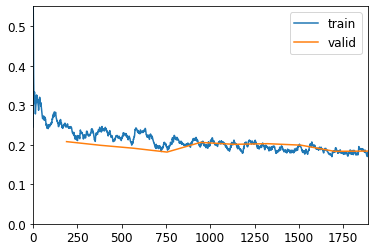

----------
regnetz_e8
----------


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.505664,0.292905,0.901186,0.539877,00:33


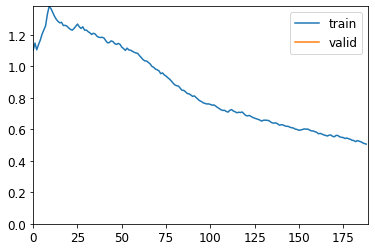

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.384497,0.282327,0.907115,0.537705,00:42
1,0.369143,0.268287,0.913702,0.628895,00:42
2,0.322299,0.251366,0.915679,0.602484,00:42
3,0.312005,0.241274,0.919631,0.653409,00:42
4,0.300562,0.235939,0.918314,0.643678,00:43
5,0.285772,0.238333,0.917655,0.661247,00:42
6,0.264406,0.231624,0.917655,0.655647,00:42
7,0.251569,0.227857,0.920290,0.664820,00:42
8,0.257423,0.226268,0.920290,0.666667,00:43
9,0.258526,0.230182,0.920290,0.666667,00:42


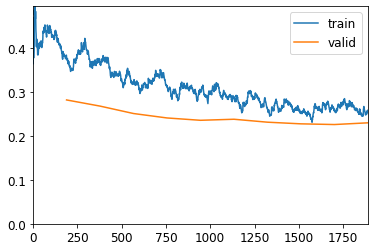

----------
resnetrs200
----------


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.443163,0.281437,0.915020,0.610272,00:59


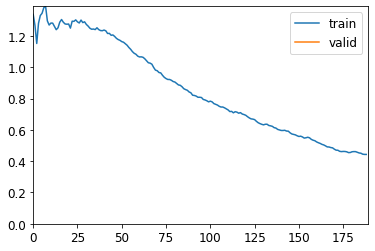

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.344792,0.277499,0.911067,0.592145,01:21
1,0.341910,0.270286,0.916337,0.638177,01:21
2,0.310005,0.270467,0.911726,0.588957,01:21
3,0.318626,0.249059,0.913043,0.597561,01:21
4,0.287729,0.238155,0.912385,0.612245,01:21
5,0.285255,0.234517,0.917655,0.631268,01:22
6,0.268301,0.235259,0.914361,0.610778,01:21
7,0.241418,0.233900,0.918972,0.639296,01:21
8,0.249084,0.230150,0.918314,0.635294,01:21
9,0.238029,0.235642,0.912385,0.598187,01:21


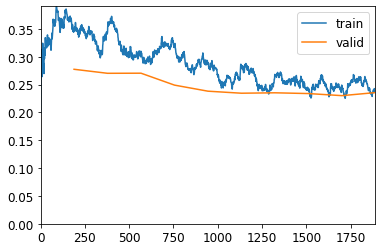

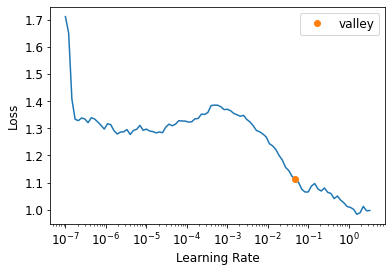

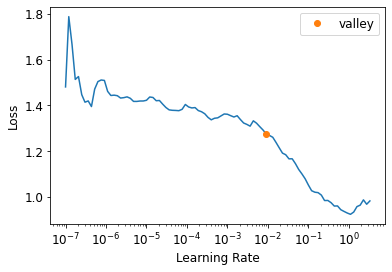

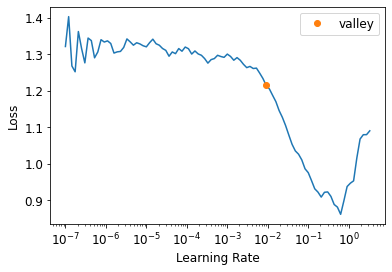

In [ ]:
train_model(dls_original,models2train, loss_func=None, opt_func=Adam, num_epochs=10)

# Data loading with Augmentation


aug_transforms is a function in the fastai library that creates a list of image augmentation transforms. The function accepts:

* `mult (default 1.0)`: multiplies the maximum value of the augmentation parameters.

- `do_flip (default True)`: whether or not to perform horizontal flipping of the images.

- `flip_vert (default False)`: whether or not to perform vertical flipping of the images.

- `max_rotate (default 10.0)`: maximum rotation angle (in degrees) to apply to the images.

- `min_zoom (default 1.0)`: minimum zoom factor to apply to the images.

- `max_zoom (default 1.1)`: maximum zoom factor to apply to the images.

- `max_lighting (default 0.2)`: maximum lighting change to apply to the images.

- `max_warp (default 0.2)`: maximum warp to apply to the images.

- `p_affine (default 0.75)`: probability of applying an affine transformation to the images.

- `p_lighting (default 0.75)`: probability of applying a lighting transformation to the images.

- `xtra_tfms (default None)`: a list of additional image augmentation transforms to apply.

- `size (default None)`: specifies the size to which the images should be resized.

- `mode (default 'bilinear')`: specifies the mode to use when resizing the images.

- `pad_mode (default 'reflection')`: specifies the mode to use when padding the images.

- `align_corners (default True)`: specifies whether to align the corners of the image during resizing.

- `batch(default False)`: specifies whether to apply the transforms on a batch of images or single image.

- `min_scale (default 1.0)`: minimum scale factor to apply to the images.

In [ ]:
tfms = aug_transforms(mult = 1.0, 
               do_flip = True, 
               flip_vert = False, 
               max_rotate = 10.0, 
               min_zoom = 1.0, 
               max_zoom = 1.1, 
               max_lighting = 0.2, 
               max_warp = 0.2, 
               p_affine  = 0.75, 
               p_lighting = 0.75, 
               xtra_tfms = None, 
               size = None, 
               mode = 'bilinear', 
               pad_mode ='reflection', 
               align_corners =True, 
               batch =False, 
               min_scale =1.0)

In [ ]:
dls_aug = ImageDataLoaders.from_csv(path='dataset',  
                                csv_fname='traindata.csv', 
                                valid_pct=0.2,
                                item_tfms=Resize(224), 
                                batch_tfms=tfms,
                                bs = 32,
                                size = 224,
                                device=device)

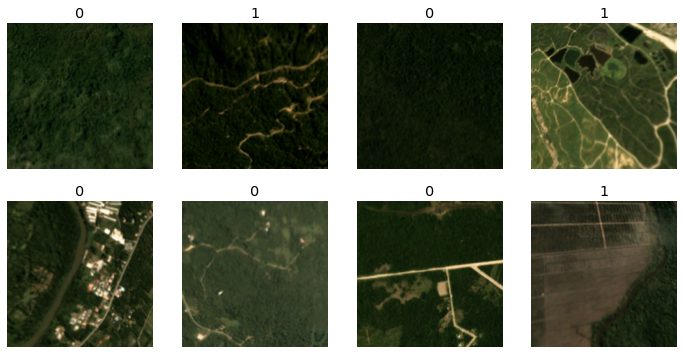

In [ ]:
dls_aug.train.show_batch(max_n=8)

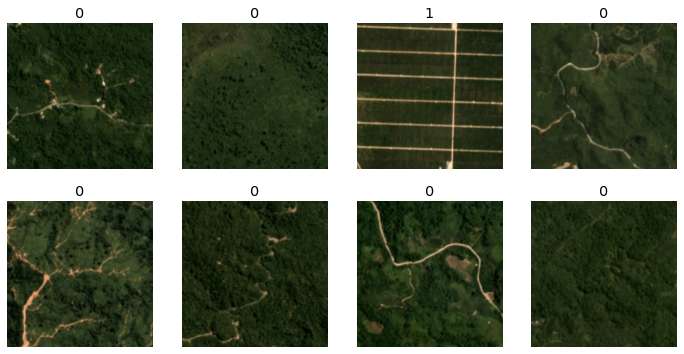

In [ ]:
dls_aug.valid.show_batch(max_n=8)

# Model training

In [ ]:
def train_model_aug(dls_aug, models2train, loss_func=None, opt_func=Adam, num_epochs=10):
  for model in models2train:
    print('-' * 10)
    print(model)
    print('-' * 10)
    learn = vision_learner(dls_aug, arch=str(model), normalize=True, n_out=None, pretrained=True,
                  loss_func=loss_func, opt_func=opt_func, splitter=None, cbs=None, metrics=[accuracy,F1Score()], path=None,
                  model_dir='models', wd=None, wd_bn_bias=False,
                  train_bn=True, moms=(0.95, 0.85, 0.95), cut=None,
                  custom_head=None, concat_pool=True, pool=True, lin_ftrs=None, ps=0.5,
                  first_bn=True, bn_final=False, lin_first=False,
                  y_range=None, n_in=3).to_fp16()
    lrs = learn.lr_find()
    base_lr = lrs.valley
    learn.fine_tune(epochs=num_epochs, base_lr=base_lr, cbs=ShowGraphCallback())
    learn.export(f"model_aug_{model}")

----------
swin_large_patch4_window7_224
----------


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.319572,0.413048,0.928854,0.698324,00:32


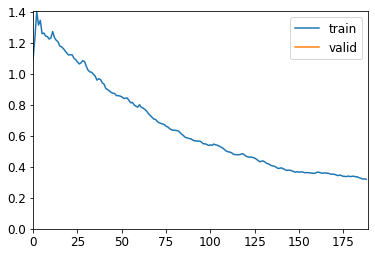

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.264025,0.306901,0.927536,0.691011,00:41
1,0.241813,0.275235,0.929513,0.700280,00:41
2,0.222514,0.249135,0.928854,0.698324,00:41
3,0.220255,0.236905,0.930171,0.713514,00:41
4,0.200202,0.236520,0.928195,0.704607,00:41
5,0.183237,0.220491,0.924901,0.674286,00:41
6,0.185465,0.227750,0.928195,0.709333,00:41
7,0.181318,0.228547,0.930171,0.715054,00:41
8,0.187960,0.223445,0.929513,0.710027,00:41
9,0.167556,0.226680,0.930171,0.715054,00:41


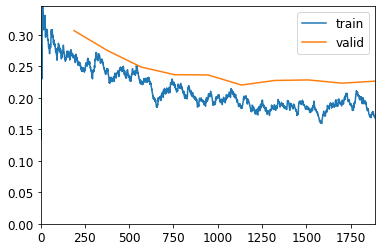

----------
regnetz_e8
----------


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.422747,0.291869,0.903821,0.455224,00:37


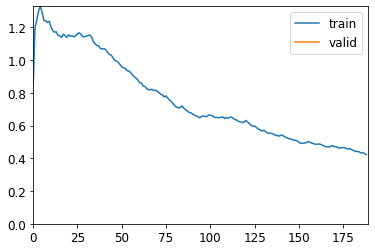

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.346595,0.276585,0.908432,0.505338,00:45
1,0.310971,0.257868,0.914361,0.569536,00:46
2,0.293195,0.253498,0.908432,0.515679,00:45
3,0.284648,0.239167,0.909750,0.501818,00:45
4,0.246797,0.237789,0.912385,0.566775,00:45
5,0.251562,0.239386,0.918314,0.624242,00:46
6,0.249940,0.229207,0.915020,0.598131,00:45
7,0.225186,0.229933,0.913702,0.581470,00:45
8,0.212899,0.226876,0.915679,0.594937,00:46
9,0.237691,0.231797,0.910408,0.555556,00:45


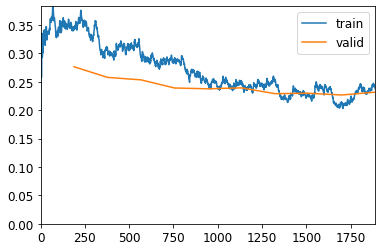

----------
resnetrs200
----------


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.402150,0.268635,0.911726,0.591463,01:02


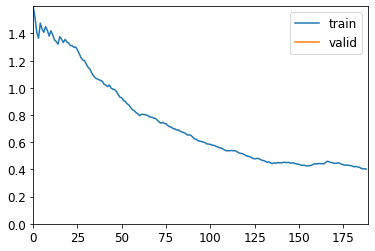

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.289708,0.266138,0.909750,0.535593,01:25
1,0.289245,0.245894,0.909091,0.543046,01:25
2,0.255440,0.244965,0.915679,0.630058,01:25
3,0.245053,0.228877,0.916996,0.615854,01:25
4,0.224969,0.225637,0.914361,0.588608,01:25
5,0.233070,0.223160,0.915679,0.602484,01:24
6,0.222683,0.216002,0.920949,0.620253,01:25
7,0.206222,0.221507,0.918972,0.641399,01:24
8,0.205244,0.221014,0.920949,0.655172,01:25
9,0.206769,0.219548,0.918972,0.630631,01:25


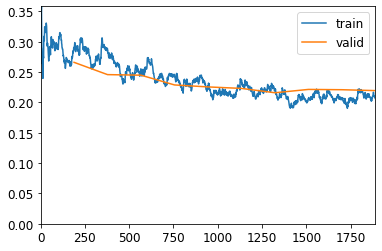

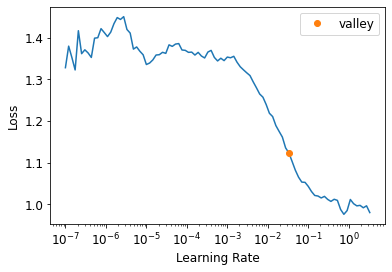

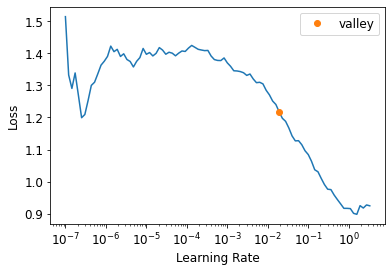

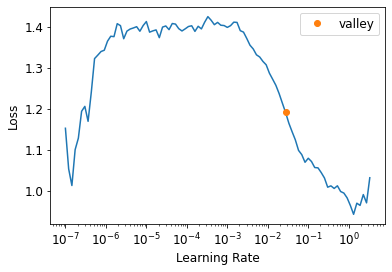

In [ ]:
train_model_aug(dls_aug, models2train, loss_func=None, opt_func=Adam, num_epochs=10)

# Reproducing best model results

## Description of vision_learner params

- `dls:` DataLoaders object that contains the training and validation data.

- `arch:` architecture of the model, it can be a pretrained model or a custom architecture.

- `normalize:` indicates whether the data should be normalized or not. The default value is True.

- `n_out:` number of outputs of the model. If not specified, will be inferred from data.

- `pretrained:` indicates whether to use a pretrained model or not, default value is True.

- `loss_func:` loss function used during training. If not specified, it will be inferred from the data.

- `opt_func:` optimizer used during training, default value is Adam.

- `lr:` learning rate used during training, default value is 0.001.

- `splitter:` used to split the model for differential learning rates.

- `cbs:` list of callbacks that are applied during training.

- `metrics:` list of metrics used to evaluate the model.

- `path:` path to the model directory where the model is saved.

- `model_dir:` name of the model directory, ddefault value is 'models'.

- `wd:` weight decay used during training.

- `wd_bn_bias:` indicates whether weight decay should be applied to the batchnorm bias or not, default value is False.

- `train_bn:` indicates whether to train the batchnorm layers or not. The default value is True.

- `moms:` tuple of floats representing the momentum for the optimizer. The default value is (0.95, 0.85, 0.95).

- `cut:` index of the cut point for the model.

- `custom_head:` custom head to use for the model.

- `concat_pool:` indicates whether to concatenate the adaptive pooling layer with the model's output, default value is True.

- `pool:` indicates whether to use an adaptive pooling layer. The default value is True.

- `lin_ftrs:` list of integers representing the number of neurons in each linear layer of the model.

- `ps:` This is the dropout probability for the model. The default value is 0.5.

- `first_bn:` indicates whether to use batchnorm in the first linear layer. The default value is True.

- `bn_final:` indicates whether to use batchnorm in the final linear layer. The default value is False.

- `lin_first:` indicates whether to use a linear layer as the first layer. The default value is False.

- `y_range:` This is the range of the target variable.

- `n_in:` number of input channels for the model, default value is 3.

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.458702,0.297537,0.916996,0.691176,00:29


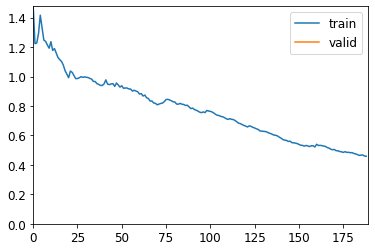

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.276645,0.271852,0.926877,0.743649,00:39
1,0.232921,0.221566,0.920949,0.715640,00:39
2,0.194718,0.224329,0.928195,0.750572,00:39
3,0.164942,0.223320,0.926877,0.747153,00:39


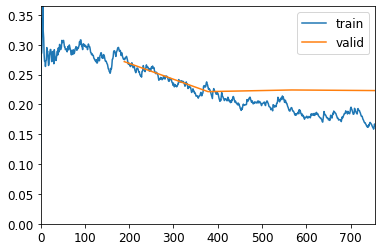

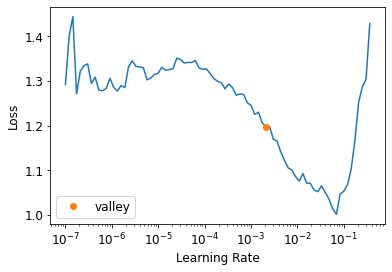

In [ ]:
best_learner = vision_learner(dls_original, 
                       arch='swin_large_patch4_window7_224', 
                       normalize=True, 
                       n_out=None, 
                       pretrained=True,
                       loss_func=None, 
                       opt_func=Adam, 
                       splitter=None, 
                       cbs=None, 
                       metrics=[accuracy,F1Score()], 
                       path=None,
                       model_dir='models', 
                       wd=None, 
                       wd_bn_bias=False,
                       train_bn=True, 
                       moms=(0.95, 0.85, 0.95), 
                       cut=None,
                       custom_head=None, 
                       concat_pool=True, 
                       pool=True, 
                       lin_ftrs=None, 
                       ps=0.5,
                       first_bn=True, 
                       bn_final=False, 
                       lin_first=False,
                       y_range=None, n_in=3).to_fp16()


lrs = best_learner.lr_find()
base_lr = lrs.valley
best_learner.fine_tune(epochs=4, base_lr=base_lr, cbs=ShowGraphCallback())

# How to find the 'best' learning rate?

The learn.lr_find() function finds the best learning rate by training the model on a small subset of the data with a range of learning rates and plotting the loss values for each learning rate.

Here's how it works:

- The method first initializes the learning rate to a very small value and gradually increases it in logarithmic scale.

- For each learning rate, the method trains the model on a small subset of the data (typically a few batches) and records the loss value.

- The method then plots the loss values against the learning rates.

- The lr_find() method can be used to find a good learning rate for the initial training and then again when fine-tuning the model. This can save a lot of time and computational resources, as it can be difficult to find a good learning rate manually.

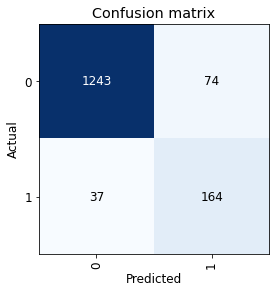

In [ ]:
interp = ClassificationInterpretation.from_learner(best_learner)
interp.plot_confusion_matrix()

# Visualizing top images that were the most difficult for the model to classify correctly

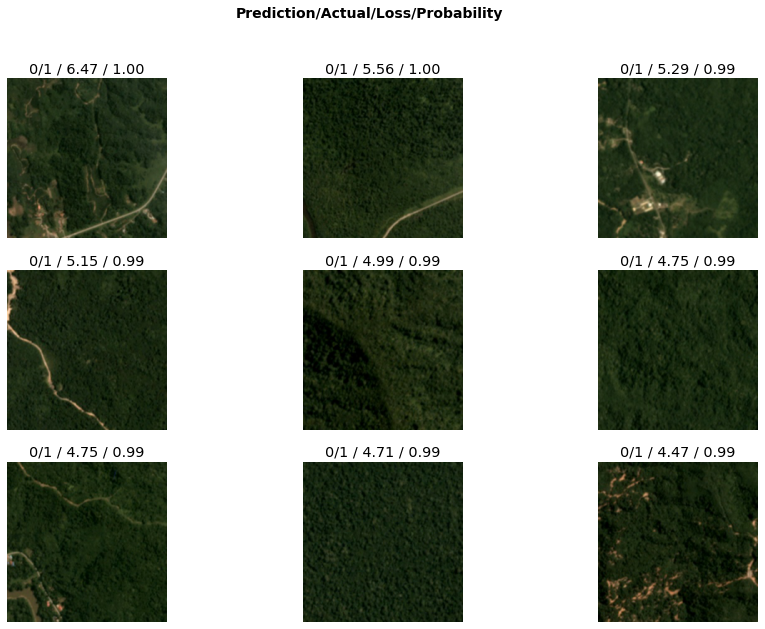

In [ ]:
interp.plot_top_losses(9, figsize=(15,10))

# Final results, comparison (ORG = original and AUG = augmentation)

| Mode   |          Model                | Accuracy  |  F1-score | Time    |
|:-------|:------------------------------|----------:|----------:|:--------|
| ORG    | swin_large_patch4_window7_224 |  0.939394 |	0.775610 | 6m 5s   |
| ORG    | regnetz_e8                    |  0.920290 |  0.666667 | 7m      |
| ORG    | resnetrs200                   |  0.912385 |	0.598187 | 13m 10s |
| AUG    | swin_large_patch4_window7_224 |  0.930171 |	0.715054 | 6m 47s  |
| AUG    | regnetz_e8                    |  0.910408 |  0.555556 | 7m 10s |
| AUG    | resnetrs200                   |  0.918972 |	0.630631 | 14m 16s |


# Inference on test set

In [3]:
import pandas as pd
import glob
from PIL import Image

In [10]:
images = glob.glob("test/*.jpg")
print(f'Number of testing images: {len(images)}')

Number of testing images: 7637


In [ ]:
df = pd.DataFrame(columns=['img_id', 'has_oilpalm'])

# iterate through the list of image file paths
for i, img_path in enumerate(images):
    # use the predict method to make a prediction
    is_palm, _, _ = best_learner.predict(PILImage.create(img_path))
    # append the results to the dataframe
    df = df.append({'img_id': img_path, 'has_oilpalm': is_palm}, ignore_index=True)

df['img_id'] = df['img_id'].str.replace('^dataset/', '', regex=True)
df = df.sort_values(by='img_id')
df.to_csv('test_results_final.csv',  index=False)

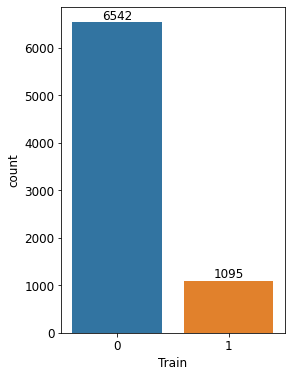

In [66]:
y = df['has_oilpalm']

fig, ax1 = plt.subplots(figsize=(4,6))

counts = y.value_counts()

ax1 = sns.countplot(x=y, ax=ax1)
ax1.bar_label(container=ax1.containers[0], labels=counts)
ax1.set_xlabel('Train')
plt.show()

# Conclusion


The computer vision community has identified a limited number of models that perform well on RGB classification tasks. Due to the availability of pretrained models on ImageNet, these tasks have become increasingly accurate. In this homework, I used Fastai, a high-level API built on top of Pytorch, to train and evaluate a series of models for binary classification task. The use of Fastai presented some challenges such as a small community, confusing documentation, and deprecated functions due to updates in the library.

In addressing the class imbalance problem, I attempted to oversample the minority class and undersample the majority class, but this did not result in an improvement in performance. I also tried to use deep data augmentation techniques such as building a VAE to generate synthetic images, but this proved unsuccessful. However, using DALLE 1-shot image variation feature resulted in surprisingly good performance, and this method should be further explored in future work.

I also generated a score metric to select the best model from a set of options based on inference speed and accuracy, which resulted in the selection of 'swin_large_patch4_window7_224', 'regnetz_e8', 'resnetrs200'. I further compared models with and without data augmentation (DA), resulting in no particular benefit. In fact, my best performing model was without DA.

It is also worth noting that the lr_find() method should be used with caution as the results may vary depending on the architecture and dataset used. 

Overall, while Fastai proved to be a useful tool for fastly training and evaluating models, it is important to have a thorough understanding of the underlying concepts and be prepared to troubleshoot any issues that may arise during the implementation process.




# References

Howard, J., & Gugger, S. (2020). Fastai: a layered API for deep learning. Information, 11(2), 108.

Marcus, G., Davis, E., & Aaronson, S. (2022). A very preliminary analysis of DALL-E 2. arXiv preprint arXiv:2204.13807.